# Two Qubit Design

## Coupled Tee Construction

In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
#This imports the necessary path to draw the single pad transmon design. 
import sys
sys.path.append('../../resources')
from single_pad_transmon_pocket import TransmonPocket_Single

import shapely
import warnings
from shapely.errors import ShapelyDeprecationWarning
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)

In [4]:
from qiskit_metal import designs, draw
from qiskit_metal import MetalGUI, Dict, Headings

from qiskit_metal.qlibrary.terminations.short_to_ground import ShortToGround
from qiskit_metal.qlibrary.terminations.open_to_ground import OpenToGround

from qiskit_metal.qlibrary.tlines.mixed_path import RouteMixed
from qiskit_metal.qlibrary.tlines.straight_path import RouteStraight

from qiskit_metal.qlibrary.couplers.coupled_line_tee import CoupledLineTee

import pyEPR as epr

In [5]:
design = designs.DesignPlanar({}, True)
design.chips.main.size['size_x'] = '10 mm'
design.chips.main.size['size_y'] = '10 mm'

design.variables['cpw_width'] = '15 um'
design.variables['cpw_gap'] = '9 um'

gui = MetalGUI(design)

In [6]:
design.delete_all_components()

In [7]:
design.delete_component('cpw_2')

01:19PM 35s INFO [delete_component]: Called delete_component cpw_2, but such a component is not in the design cache dictionary of components.


True

In [8]:
design.overwrite_enabled = True #This makes it possible to edit the designs later on. 



options = dict(pad_width = '250 um',
pocket_width = '300 um',
pad_pocket_distance_top = '60 um',
connection_pads = dict(
    a = dict(loc_W  = 1, 
             loc_H =  1, 
             pad_gap = '10 um',
             pad_height = '20 um',
             pad_width = '100 um',
             pad_cpw_extent =  '10 um',
             pocket_rise = '0 um',
             cpw_extend = '5 um')))

q1 = TransmonPocket_Single(design,'Q1',options = dict(pos_x = '1 mm', 
                                                      pos_y = '0',
                                                      pad_height = '200 um', 
                                                      **options))
q2 = TransmonPocket_Single(design,'Q2',options = dict(pos_x = '0.39 mm', 
                                                      pos_y = '-0.7', 
                                                      pad_height = '220 um', 
                                                      **options))

gui.rebuild()
gui.zoom_on_components(['Q1','Q2'])

In [9]:
design.variables['cpw_width']

'15 um'

In [10]:
design.parse_value(q1.options.pos_x)

1

In [78]:
# design.delete_all_components()

# prime_width='10um',
#                            prime_gap='6um',
#                            second_width='10um',
#                            second_gap='6um',
#                            coupling_space='3um',
#                            coupling_length='100um',
#                            down_length='100um',
#                            fillet='25um',
#                            mirror=False,
#                            open_termination=True)

TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = design.variables['cpw_width'],
               second_gap = design.variables['cpw_gap'],
               downlength = '30um',
               coupling_space = '5um',
               open_termination=False)

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='1.35 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.15 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', mirror = True, **TQ_options))

gui.rebuild()
gui.autoscale()

In [12]:
import numpy as np
from collections import OrderedDict

def pins_for_spiral(radius,gap,n,dis = ('0','0'),no_last = False):
    spiral_list = OrderedDict()
    radius = design.parse_value(radius)
    gap = design.parse_value(gap)
    x = design.parse_value(dis[0])
    y = design.parse_value(dis[1])
    for step in range(n):
        point_value = radius / 2 + step * (0 + gap)
        spiral_list[step*4] = np.array([x+point_value, y-point_value])
        spiral_list[step*4+1] = np.array([x-point_value, y-point_value])
        spiral_list[step*4+2] = np.array([x-point_value, y+point_value])
        if no_last & (step==n-1):
            # spiral_list[step*4+3] = np.array([x+point_value + (0 + gap), y+point_value])
            break
        spiral_list[step*4+3] = np.array([x+point_value + (0 + gap), y+point_value])

    point_value = radius / 2 + (step + 1) * (0 + gap)
    # spiral_list[step*4+4] = np.array([-point_value, -point_value])
    return(spiral_list)

In [13]:
anchors_1 = pins_for_spiral('0.4 mm','0.1 mm',2,dis = (q1.options.pos_x,q1.options.pos_y))
anchors_2 = pins_for_spiral('0.4 mm','0.1 mm',2,dis = (q2.options.pos_x,q2.options.pos_y),no_last=True)
print(anchors_1)
print(anchors_2)

OrderedDict([(0, array([ 1.2, -0.2])), (1, array([ 0.8, -0.2])), (2, array([0.8, 0.2])), (3, array([1.3, 0.2])), (4, array([ 1.3, -0.3])), (5, array([ 0.7, -0.3])), (6, array([0.7, 0.3])), (7, array([1.4, 0.3]))])
OrderedDict([(0, array([ 0.59, -0.9 ])), (1, array([ 0.19, -0.9 ])), (2, array([ 0.19, -0.5 ])), (3, array([ 0.69, -0.5 ])), (4, array([ 0.69, -1.  ])), (5, array([ 0.09, -1.  ])), (6, array([ 0.09, -0.4 ]))])


In [14]:
options_1 = Dict(total_length='4 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='20 um',
        lead = dict(start_straight='20 um', end_straight = '0 um'),
        anchors = anchors_1,
        pin_inputs=Dict(
            start_pin=Dict(component='Q1', pin='a'),
            end_pin=Dict(component='TQ1', pin='second_end')), )

options_2 = Dict(total_length='3.5 mm',
        hfss_wire_bonds = True,
        q3d_wire_bonds = True,
        fillet='20 um',
        lead = dict(start_straight='20 um', end_straight = '0 um'),
        anchors = anchors_2,
        pin_inputs=Dict(
            start_pin=Dict(component='Q2', pin='a'),
            end_pin=Dict(component='TQ2', pin='second_end')), )

In [15]:
CPW1 = RouteMixed(design, 'cpw_1', options_1)
CPW2 = RouteMixed(design, 'cpw_2', options_2)



gui.rebuild()
gui.autoscale()

In [16]:
ops_mid = Dict(hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_start'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_end')))

cpw_middle = RouteStraight(design, 'cpw_middle', options=ops_mid)

gui.rebuild()
gui.autoscale()

In [39]:

width = design.variables['cpw_gap'] +' + '+ design.variables['cpw_gap'] + ' + '  + design.variables['cpw_width']

open_left = OpenToGround(design,'left',options = dict(pos_x = '-0.5mm',pos_y = '0.5mm',orientation = '180'))
open_right = OpenToGround(design,'right',options = dict(pos_x = '2mm',pos_y = '0.5mm',orientation = '0'))

ops_ends_left = dict(width = width, hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='TQ1',
                     pin='prime_end'),
                 end_pin=Dict(
                     component='right',
                     pin='open')))

ops_ends_right = dict(width = width, hfss_wire_bonds = True,
               pin_inputs=Dict(
                 start_pin=Dict(
                     component='left',
                     pin='open'),
                 end_pin=Dict(
                     component='TQ2',
                     pin='prime_start')))

cpw_left = RouteStraight(design, 'cpw_left', options=ops_ends_left)
cpw_right = RouteStraight(design, 'cpw_right', options=ops_ends_right)

gui.rebuild()
gui.autoscale()

'9 um + 9 um+15 um'

## Simulations

### Capacitance Matrix

In [79]:
TQ_options = dict(prime_width = design.variables['cpw_width'],
               prime_gap = design.variables['cpw_gap'],
               second_width = design.variables['cpw_width'],
               second_gap = design.variables['cpw_gap'],
               downlength = '30um',
               coupling_space = '-5um',
               open_termination=True)

TQ1 = CoupledLineTee(design, 'TQ1', options=dict(pos_x='1.35 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', **TQ_options))
TQ2 = CoupledLineTee(design, 'TQ2', options=dict(pos_x='0.15 mm',
                                             pos_y='0.5 mm',
                                             coupling_length='120 um', mirror = True, **TQ_options))

gui.rebuild()
gui.autoscale()

In [80]:
from qiskit_metal.analyses.quantization import LOManalysis
c1 = LOManalysis(design, "q3d")

In [81]:
c1.sim.setup.min_passes  = 1
c1.sim.setup.max_passes = 5
print(c1.sim.setup)

{'name': 'Setup', 'reuse_selected_design': True, 'reuse_setup': True, 'freq_ghz': 5.0, 'save_fields': False, 'enabled': True, 'max_passes': 5, 'min_passes': 1, 'min_converged_passes': 2, 'percent_error': 0.5, 'percent_refinement': 30, 'auto_increase_solution_order': True, 'solution_order': 'High', 'solver_type': 'Iterative'}


In [82]:
c1.sim.run(components=['cpw_1','Q1','TQ1','cpw_2','Q2','TQ2','cpw_middle','cpw_left','cpw_right','left','right'],
            open_terminations=[('left', 'open'),('right','open')])#, ('Q1', 'bus1'), ('Q1', 'bus2')])
c1.sim.capacitance_matrix 

c1.sim._get_results_from_renderer()
c_mat = c1.sim.capacitance_matrix

INFO 04:36PM [connect_design]: 	Opened active design
	Design:    Design_q3d [Solution type: Q3D]
INFO 04:36PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.AnsysQ3DSetup'>)
INFO 04:36PM [analyze]: Analyzing setup Setup
INFO 04:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmp61rk8v6d.txt, C, , Setup:LastAdaptive, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpsgl_wf47.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 1, False
INFO 04:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpe3zce69f.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, Maxwell, 2, False
INFO 04:36PM [get_matrix]: Exporting matrix data to (C:\Users\slab\AppData\Local\Temp\tmpr6a7xqj5.txt, C, , Setup:AdaptivePass, "Original", "ohm", "nH", "fF", "mSie", 5000000000, 

In [83]:
c_mat

,a_connector_pad_Q1,a_connector_pad_Q2,g_wb,pad_top_Q1,pad_top_Q2,prime_cpw_TQ1
a_connector_pad_Q1,626.69431,-0.49339,-599.58247,-17.78549,-0.27345,-6.76679
a_connector_pad_Q2,-0.49339,628.42504,-600.55762,-0.24064,-18.98314,-6.10926
g_wb,-599.58247,-600.55762,1822.23722,-77.32631,-82.35751,-342.80308
pad_top_Q1,-17.78549,-0.24064,-77.32631,96.62331,-0.14565,-0.28841
pad_top_Q2,-0.27345,-18.98314,-82.35751,-0.14565,102.73319,-0.06000
prime_cpw_TQ1,-6.76679,-6.10926,-342.80308,-0.28841,-0.06000,357.37539


### EPR Analysis

In [17]:
import numpy as np
from qiskit_metal.analyses.quantization import EPRanalysis

In [89]:
hfss.clean_active_design()

INFO 05:02PM [connect_project]: Connecting to Ansys Desktop API...
INFO 05:02PM [load_ansys_project]: 	Opened Ansys App
INFO 05:02PM [load_ansys_project]: 	Opened Ansys Desktop v2022.2.0
INFO 05:02PM [load_ansys_project]: 	Opened Ansys Project
	Folder:    C:/Users/slab/Documents/Ansoft/
	Project:   Project11
INFO 05:02PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]
INFO 05:02PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)
INFO 05:02PM [connect]: 	Connected to project "Project11" and design "readout" 😀 

INFO 05:02PM [connect_design]: 	Opened active design
	Design:    readout [Solution type: Eigenmode]


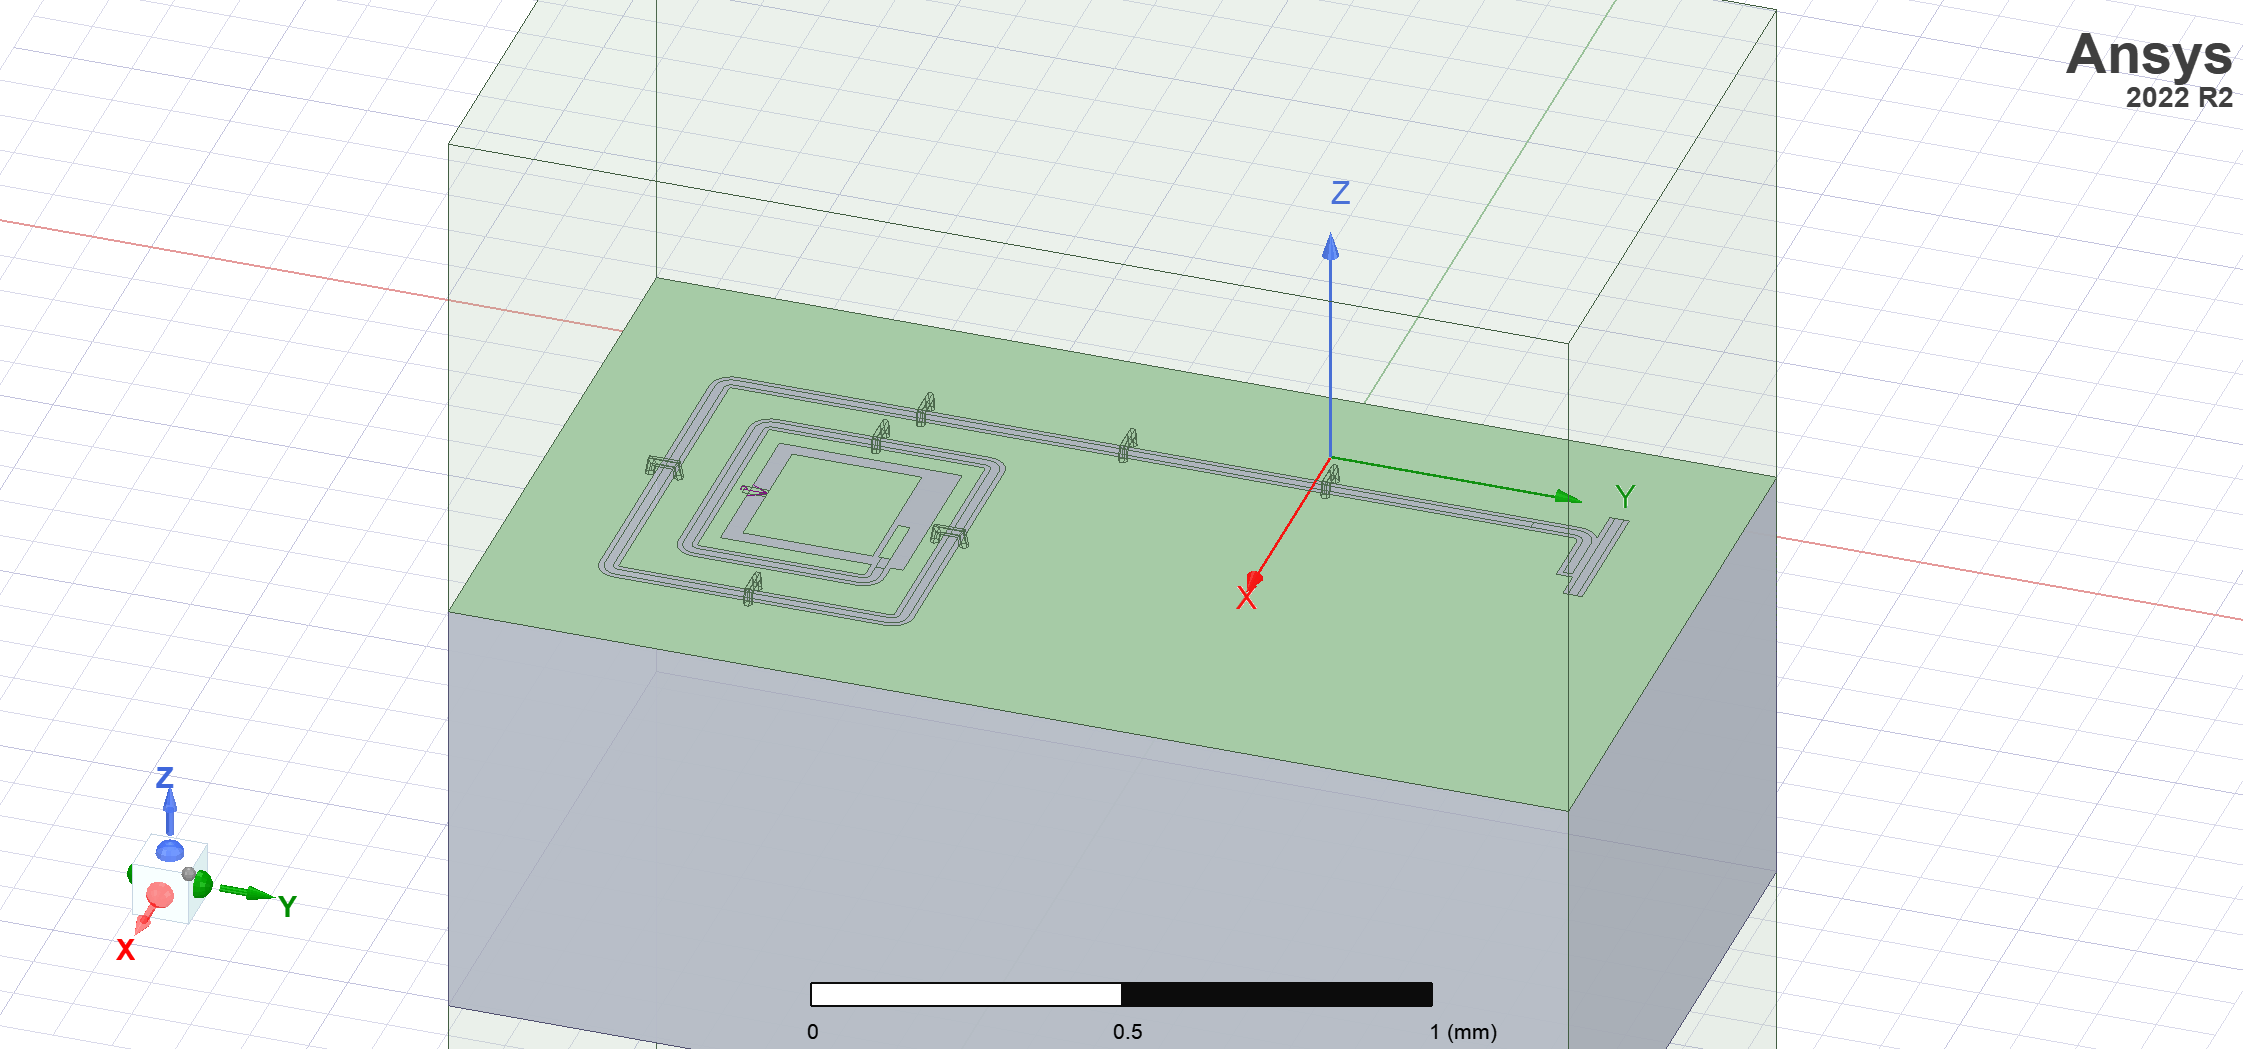

INFO 05:03PM [analyze]: Analyzing setup Setup



Number of eigenmodes to find             = 3
Number of simulation passes              = 20
Convergence freq max delta percent diff  = 0.1



In [90]:
eig_res = EPRanalysis(design, "hfss")

hfss = eig_res.sim.renderer
hfss.start()

hfss.activate_ansys_design('readout','eigenmode')

hfss.render_design(['cpw_2','Q2','TQ2'],[])
hfss.save_screenshot()

setup = hfss.pinfo.setup
setup.passes = 20
setup.min_converged = 2
setup.n_modes = 3

print(f"""
Number of eigenmodes to find             = {setup.n_modes}
Number of simulation passes              = {setup.passes}
Convergence freq max delta percent diff  = {setup.delta_f}
""")

# Next 2 lines are counterinuitive, since there is no junction in this resonator.
# However, these are necessary to make pyEPR work correctly. Please do note delete
hfss.pinfo.design.set_variable('Lj', '10 nH')
hfss.pinfo.design.set_variable('Cj', '0 fF')

setup.analyze()

In [87]:
eig_res.get_frequencies()

Design "readout" info:
	# eigenmodes    3
	# variations    1
Design "readout" info:
	# eigenmodes    3
	# variations    1


Freq. (GHz)  Quality Factor
variation mode                             
0         0        5.920327             inf
          1       13.459082             inf
          2       26.797450             inf

In [88]:
eig_res.sim.convergence_t, eig_res.sim.convergence_f, _ = hfss.get_convergences()
eig_res.sim.plot_convergences()

05:02PM 27s INFO [get_f_convergence]: Saved convergences to c:\Users\slab\Desktop\Qiskit_metal_tutorial\tutorials\4 Analysis\A. Core - EM and quantization\hfss_eig_f_convergence.csv


INFO 04:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


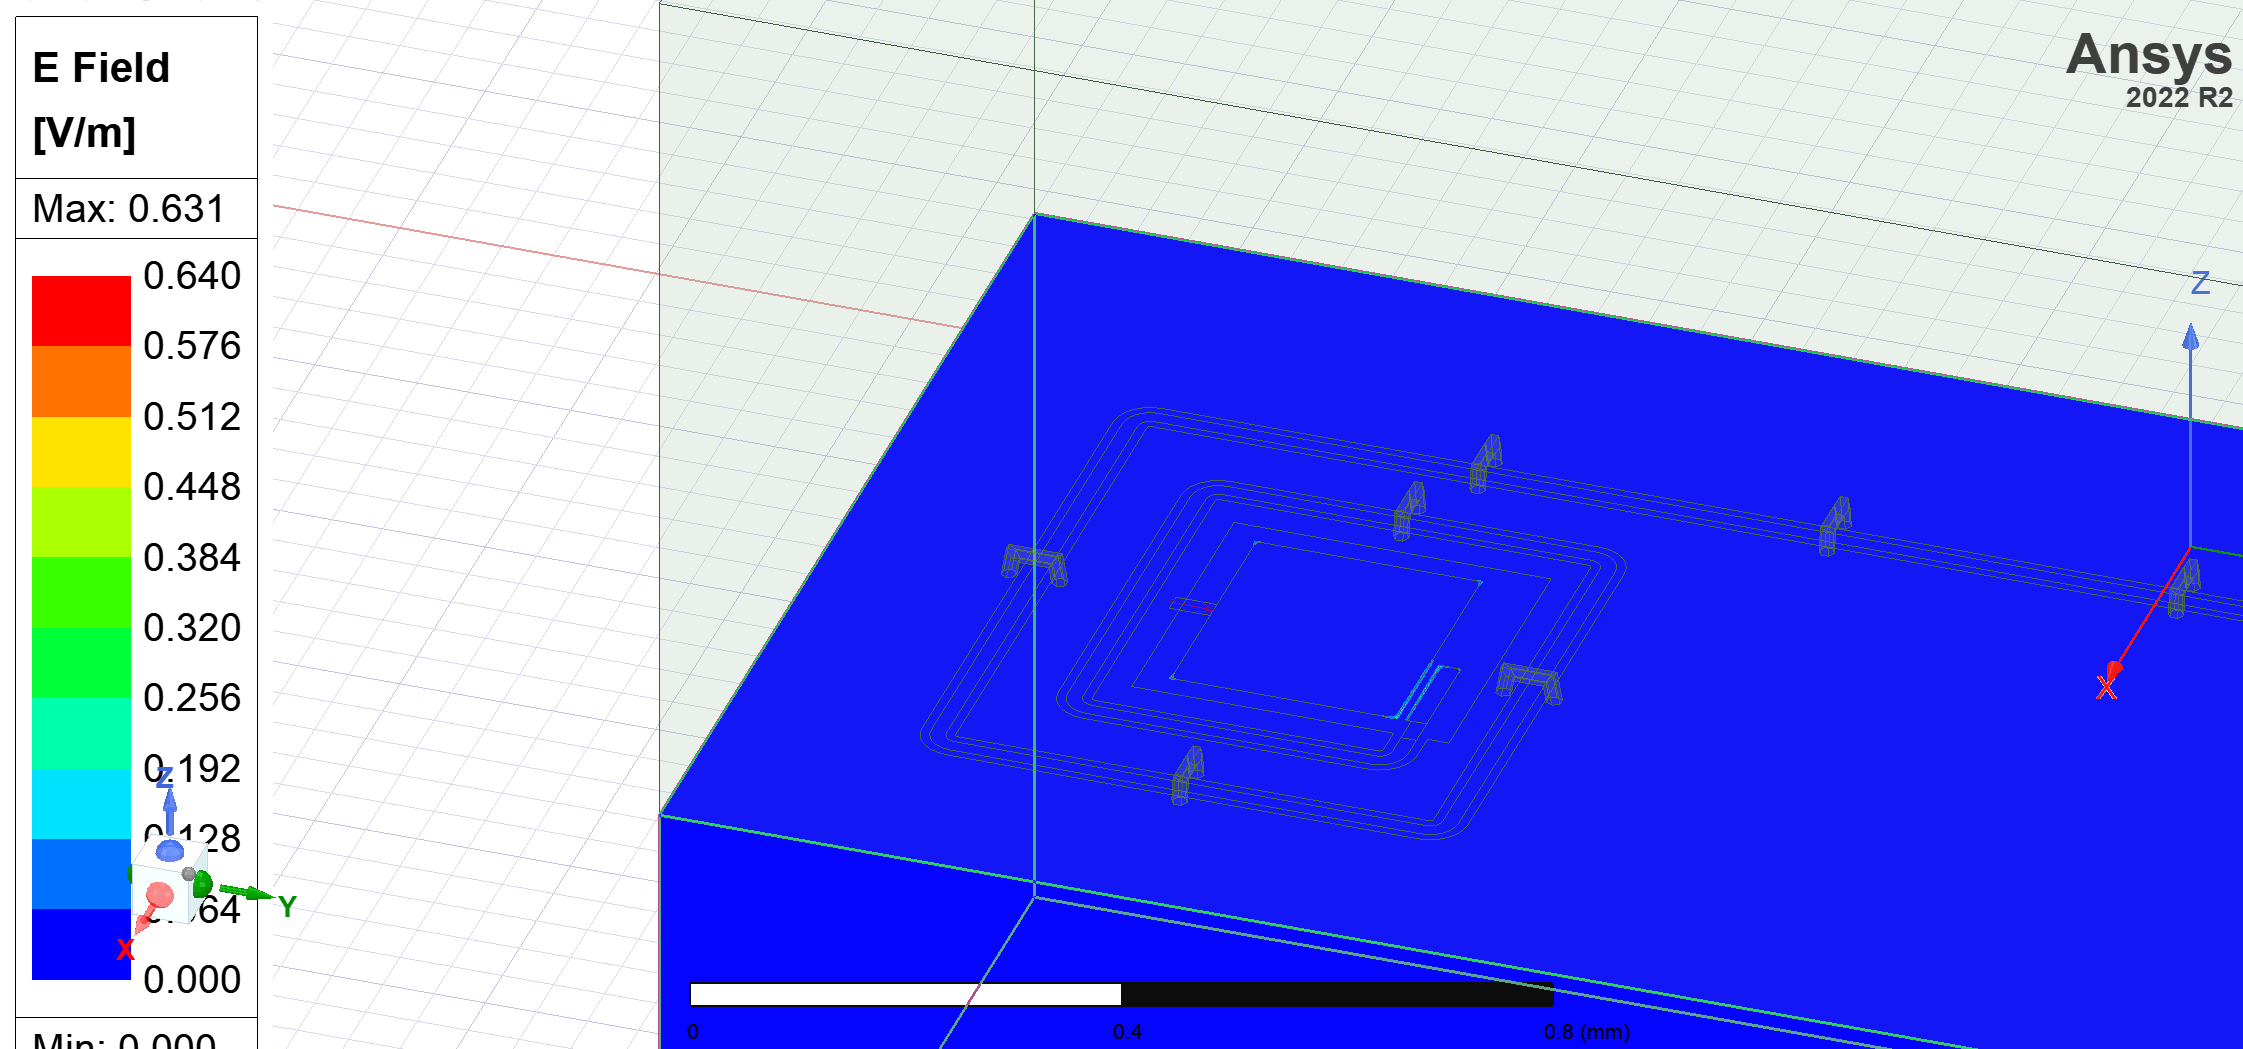

WindowsPath('c:/Users/slab/Desktop/Qiskit_metal_tutorial/tutorials/4 Analysis/A. Core - EM and quantization/ansys.png')

In [68]:
hfss.set_mode(1, "Setup")

hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()


In [69]:
hfss.clear_fields(['Mag_E1'])

In [70]:
hfss.set_mode(2, "Setup")

INFO 04:30PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


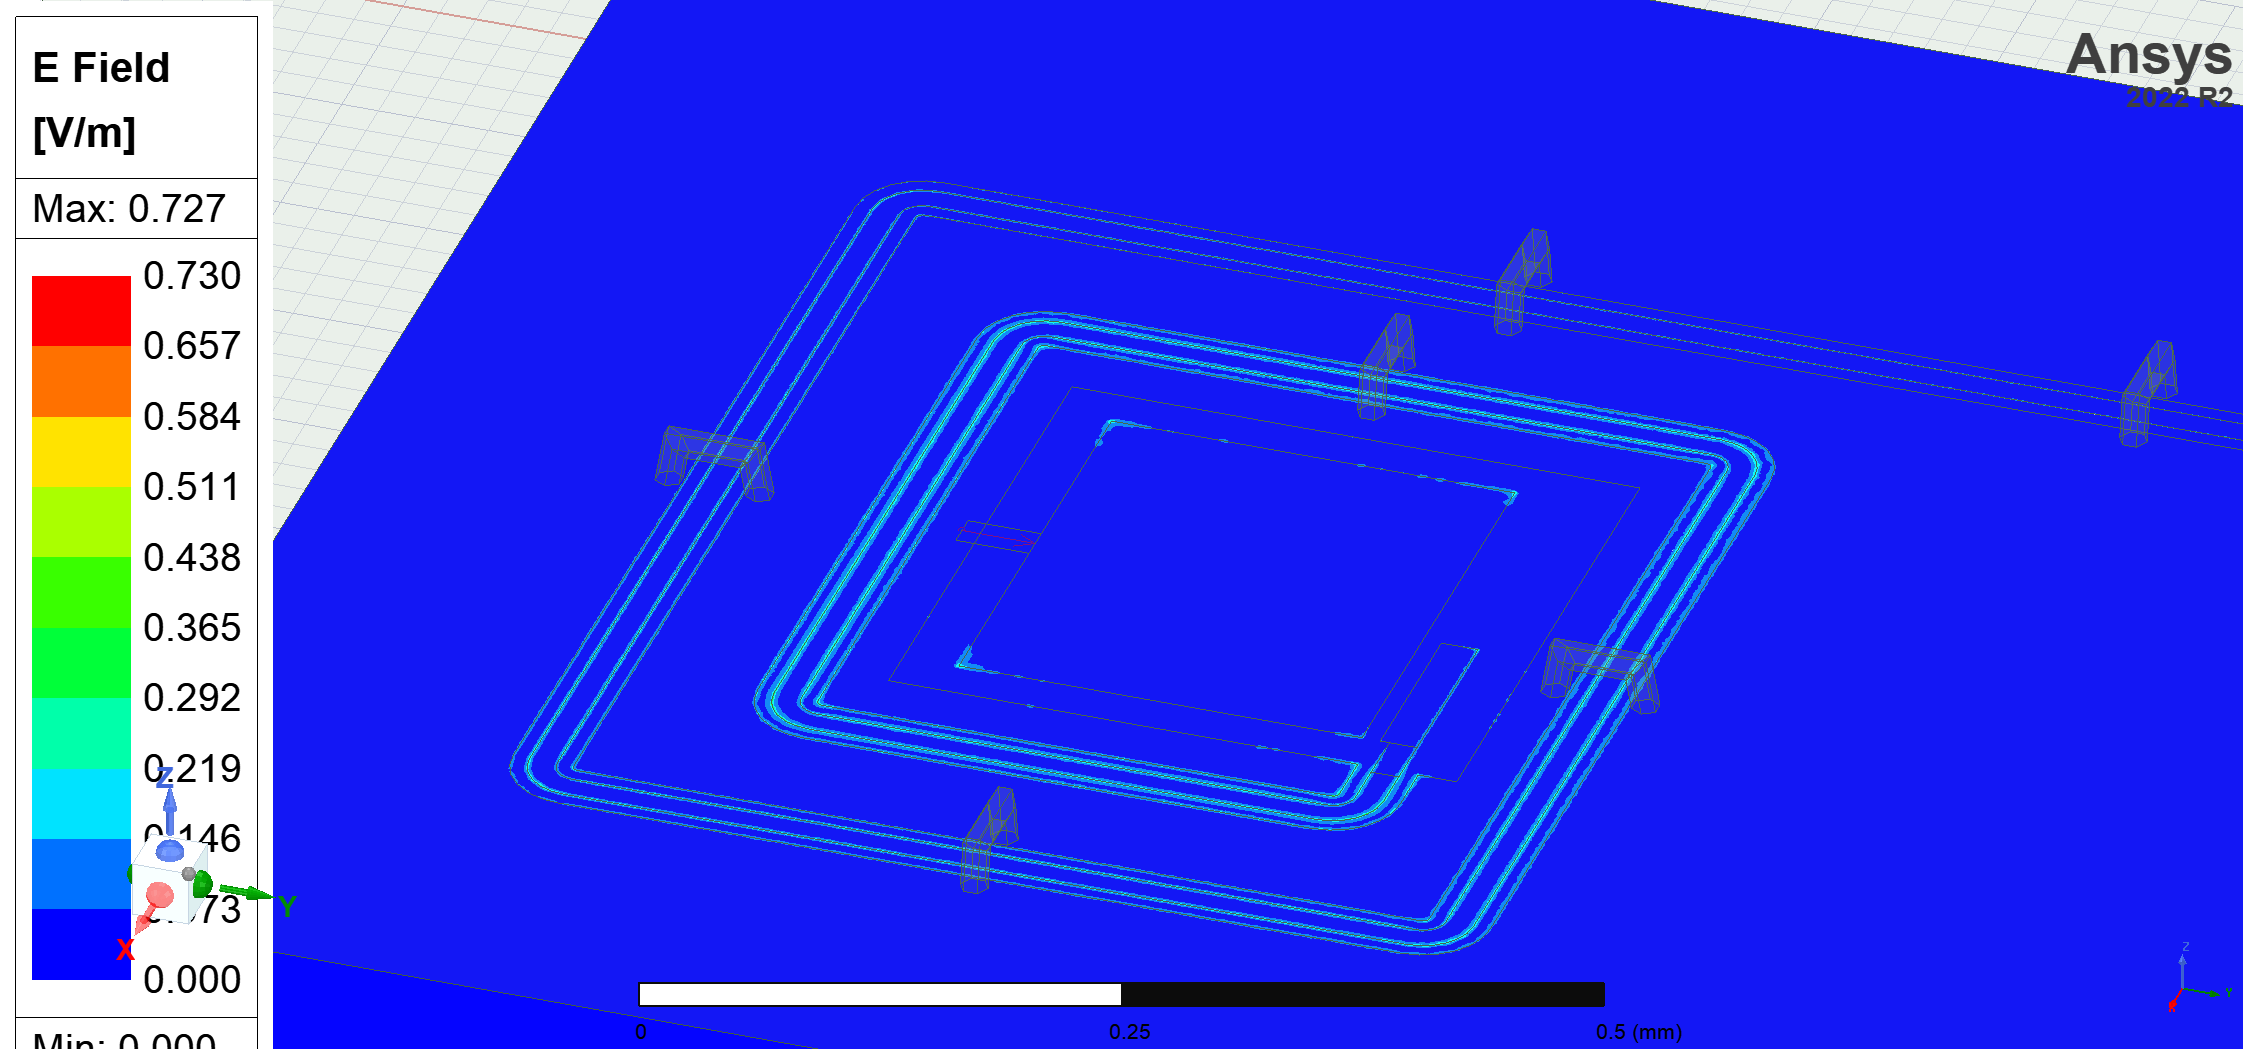

WindowsPath('c:/Users/slab/Desktop/Qiskit_metal_tutorial/tutorials/4 Analysis/A. Core - EM and quantization/ansys.png')

In [71]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [63]:
hfss.clear_fields(['Mag_E1'])

hfss.set_mode(3, "Setup")

INFO 04:27PM [get_setup]: 	Opened setup `Setup`  (<class 'pyEPR.ansys.HfssEMSetup'>)


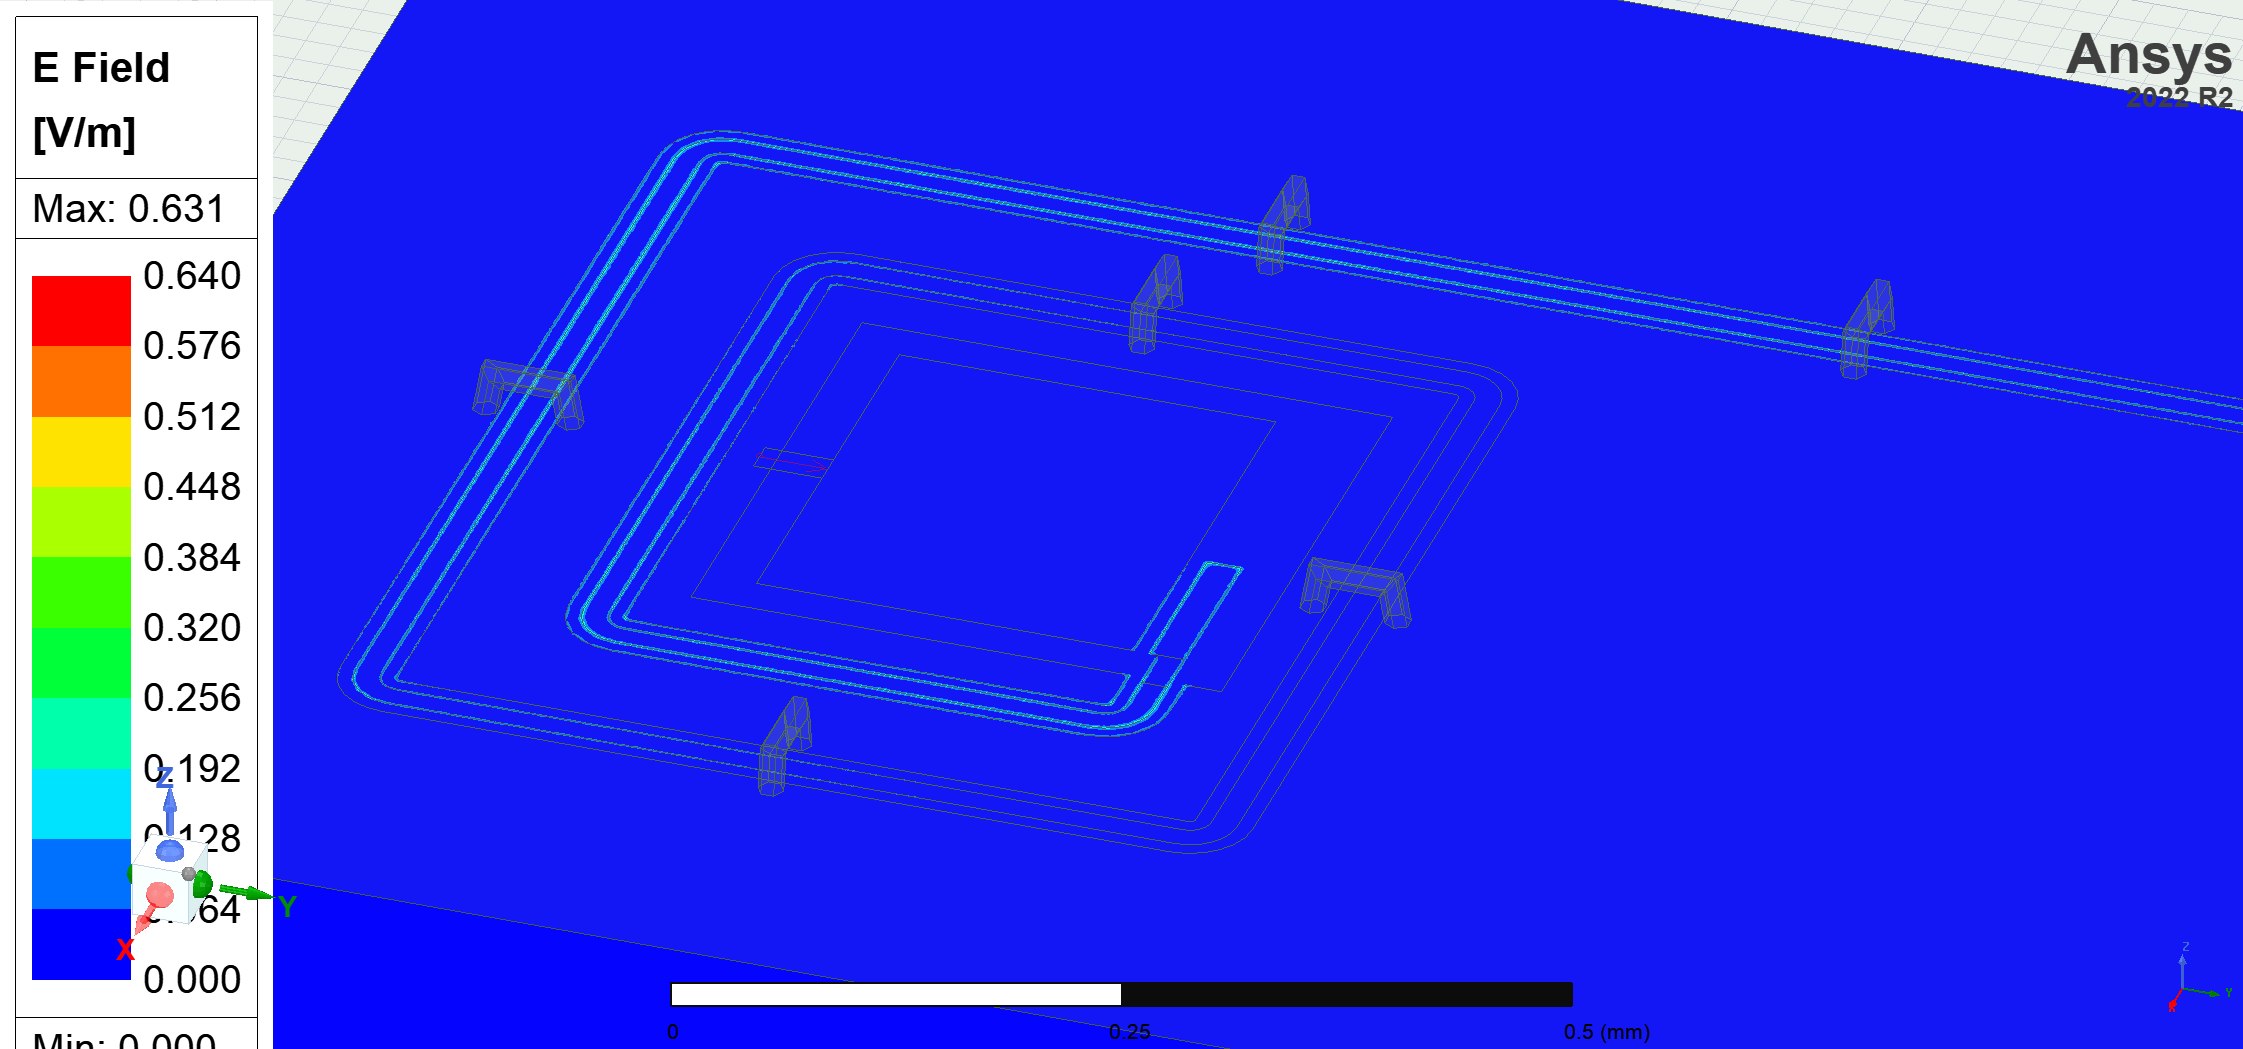

WindowsPath('c:/Users/slab/Desktop/Qiskit_metal_tutorial/tutorials/4 Analysis/A. Core - EM and quantization/ansys.png')

In [64]:
hfss.modeler._modeler.ShowWindow()
hfss.plot_fields('main')
hfss.save_screenshot()

In [27]:
hfss.close()

Warning! 3 COM references still alive
Ansys will likely refuse to shut down


True

In [198]:
gui.main_window.close()


True

## Save Design to GDS

In [51]:
a_gds = design.renderers.gds

In [52]:
a_gds.options

{'short_segments_to_not_fillet': 'True',
 'check_short_segments_by_scaling_fillet': '2.0',
 'gds_unit': 0.001,
 'ground_plane': 'True',
 'negative_mask': {'main': []},
 'fabricate': 'False',
 'corners': 'circular bend',
 'tolerance': '0.00001',
 'precision': '0.000000001',
 'width_LineString': '10um',
 'path_filename': '../resources/Fake_Junctions.GDS',
 'junction_pad_overlap': '5um',
 'max_points': '199',
 'cheese': {'datatype': '100',
  'shape': '0',
  'cheese_0_x': '25um',
  'cheese_0_y': '25um',
  'cheese_1_radius': '100um',
  'view_in_file': {'main': {1: True}},
  'delta_x': '100um',
  'delta_y': '100um',
  'edge_nocheese': '200um'},
 'no_cheese': {'datatype': '99',
  'buffer': '25um',
  'cap_style': '2',
  'join_style': '2',
  'view_in_file': {'main': {1: True}}},
 'bounding_box_scale_x': '1.2',
 'bounding_box_scale_y': '1.2'}

In [53]:
a_gds.options['path_filename'] = '../resources/Fake_Junctions.GDS'

In [54]:

a_gds.options['short_segments_to_not_fillet'] = 'False'
a_gds.export_to_gds('Two PAd design.gds')

03:13PM 51s WARNING [_import_junction_gds_file]: Not able to find file:"../resources/Fake_Junctions.GDS".  Not used to replace junction. Checked directory:"c:\Users\slab\Desktop\Qiskit_metal_tutorial\tutorials\4 Analysis\resources".


1